# SHAP Interaction
使用 SHAP python 软件包识别数据中的交互作用

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')

import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import shap
shap.initjs()

import os
dp = os.environ.get('pub_data')

## Dataset

In [94]:
# import dataset
data = pd.read_csv(dp + "Interaction_Dataset2.csv",sep='\t')

y = data['bonus']
X = data.drop('bonus', axis=1)

print(len(data))
data.head()

1000


,experience,degree,performance,sales,days_late,bonus
0,31,1,6.11,29,14,197
1,35,1,9.55,44,8,314
2,9,1,2.64,26,20,88
3,40,1,0.22,13,7,233
4,18,1,6.46,11,13,108


## Modelling

In [106]:
# Train model
model = xgb.XGBRegressor(objective="reg:squarederror",max_depth=3) 
model.fit(X, y)

# Get predictions
y_pred = model.predict(X)

Text(0.5, 0, 'Actual')

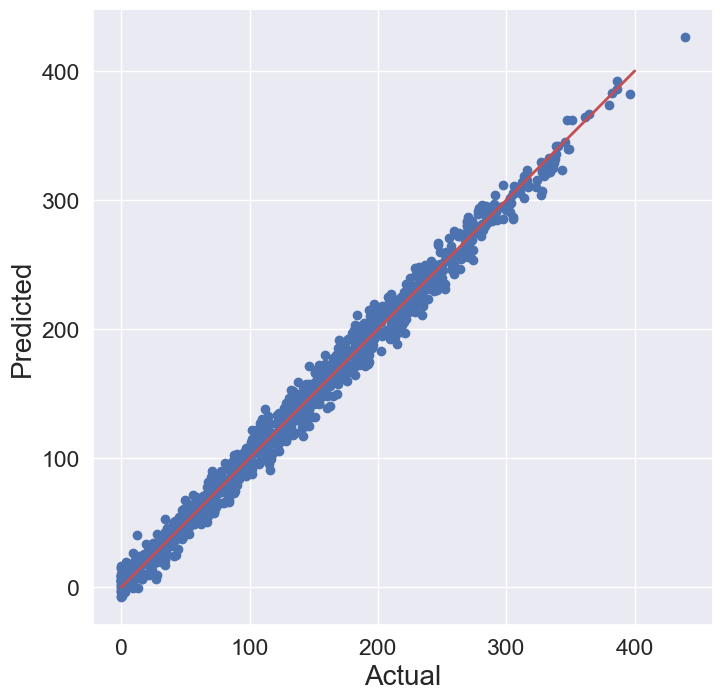

In [ ]:
# Model evaluation
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(8,8))

plt.scatter(y,y_pred)
plt.plot([0, 400], [0, 400], color='r', linestyle='-', linewidth=2)

plt.ylabel('Predicted',size=20)
plt.xlabel('Actual',size=20)

# plt.savefig('../figures/regression_evaluation.png',dpi=200,bbox_inches='tight')

In [125]:
X

,experience,degree,performance,sales,days_late
0,31,1,6.11,29,14
1,35,1,9.55,44,8
2,9,1,2.64,26,20
3,40,1,0.22,13,7
4,18,1,6.46,11,13
...,...,...,...,...,...
995,8,1,4.10,76,17
996,25,0,1.66,13,5
997,20,1,8.95,52,11
998,16,1,9.40,91,15


## SHAP interaction values

In [108]:
# Get SHAP interaction values
explainer = shap.TreeExplainer(model)
shap_interaction = explainer.shap_interaction_values(X)

In [109]:
# Get shape of interaction values
print(np.shape(shap_interaction))

# SHAP interaction values for first employee
pd.DataFrame(shap_interaction[0],index=X.columns,columns=X.columns)

(1000, 5, 5)


,experience,degree,performance,sales,days_late
experience,38.225559,8.759173,3.543329,1.424067,0.656279
degree,8.759176,28.827873,-0.037719,1.704085,0.001466
performance,3.543324,-0.037724,10.167676,-2.549232,-0.544856
sales,1.424076,1.704084,-2.549232,-29.143391,0.772711
days_late,0.656275,0.001463,-0.544855,0.772711,-4.866461


In [110]:
# Get model predictions
y_pred = model.predict(X)

# Calculate mean prediction 
mean_pred = np.mean(y_pred)

# Sum of interaction values for first employee
sum_shap = np.sum(shap_interaction[0])

print("Model prediction: {}".format(y_pred[0]))
print("Mean prediction + interaction values: {}".format(mean_pred+sum_shap))

print(mean_pred, sum_shap)

Model prediction: 219.60105895996094
Mean prediction + interaction values: 219.60107421875
148.93123 70.66985


In [111]:
print(X[(X['experience'] == 31) & (X['days_late'] == 14)])

   experience  degree  performance  sales  days_late
0          31       1         6.11     29         14


In [112]:
#Get SHAP values
explainer = shap.Explainer(model,X[0:10])
shap_values = explainer(X, check_additivity=False)

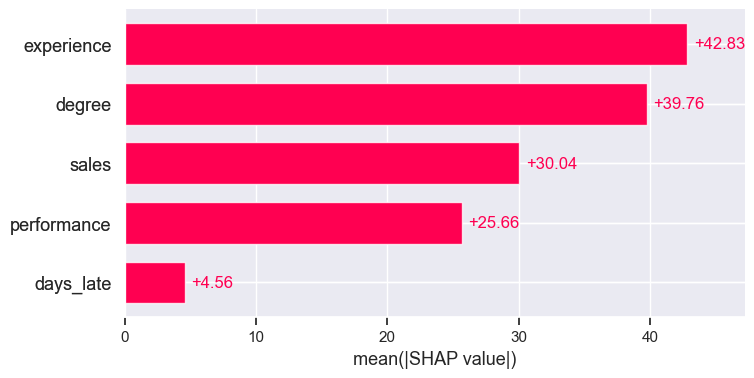

In [127]:
# Which features do NOT have a significant relationship with bonus?
# Answer: days_late
shap.plots.bar(shap_values)

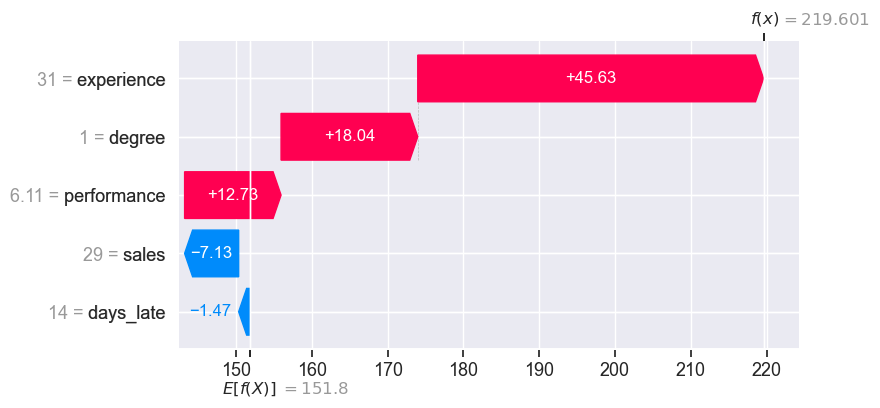

In [114]:
shap.plots.waterfall(shap_values[0])

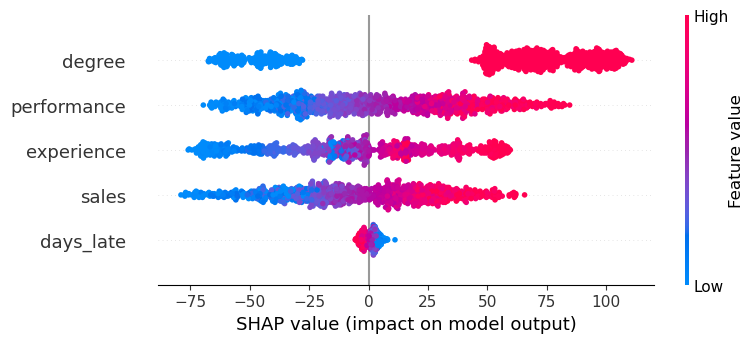

In [80]:
#What tends to happens to an employee's bonus as they gain more experience? 
# Answer: their bonus increases
# You could have also used a dependency plot
shap.plots.beeswarm(shap_values)

### Absolute mean

(array([0.5, 1.5, 2.5, 3.5, 4.5]),
 [Text(0, 0.5, 'experience'),
  Text(0, 1.5, 'degree'),
  Text(0, 2.5, 'performance'),
  Text(0, 3.5, 'sales'),
  Text(0, 4.5, 'days_late')])

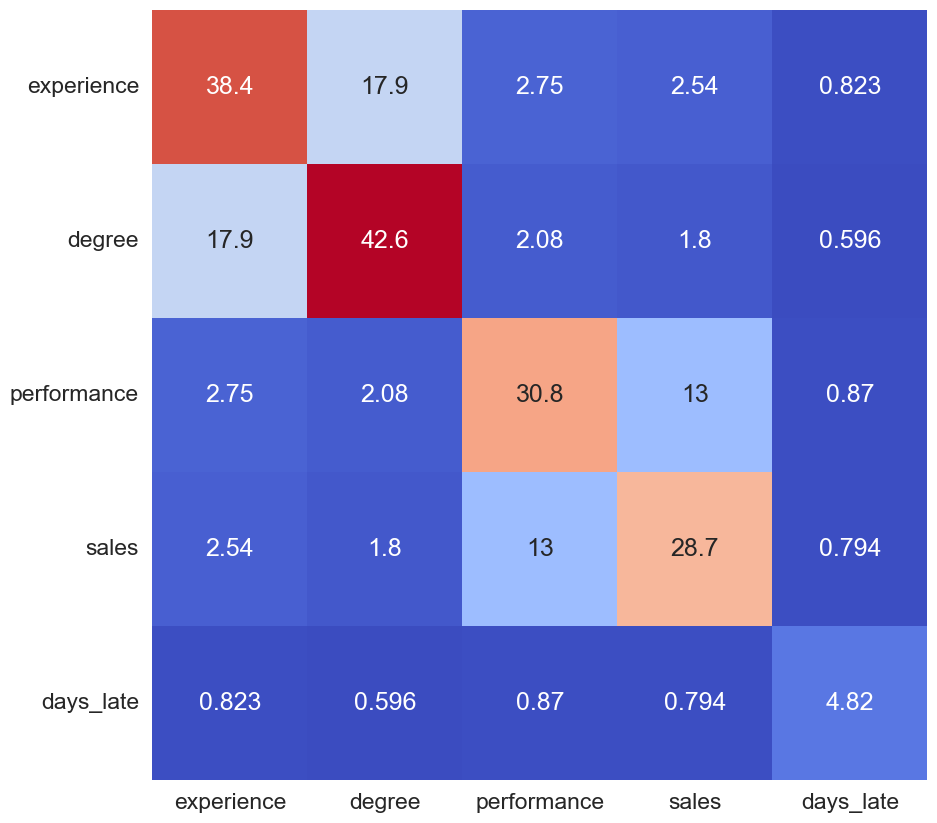

In [12]:
# Get absolute mean of matrices
mean_shap = np.abs(shap_interaction).mean(0)
df = pd.DataFrame(mean_shap,index=X.columns,columns=X.columns)

# times off diagonal by 2
df.where(df.values == np.diagonal(df),df.values*2,inplace=True)

# display 
plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
sns.set(font_scale=1.5)
sns.heatmap(df,cmap='coolwarm',annot=True,fmt='.3g',cbar=False)
plt.yticks(rotation=0) 

# plt.savefig('../../../figures/abs_mean_shap.png',dpi=200,bbox_inches='tight')

### Summary Plot

<Axes: xlabel='SHAP value (impact on model output)'>

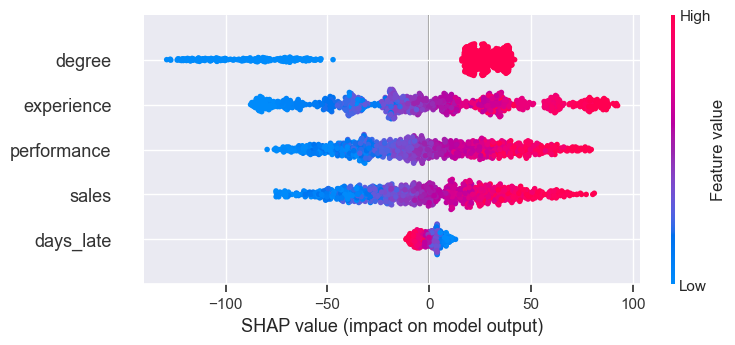

In [13]:
# Get SHAP values
shap_values = explainer(X)

# Display beeswarm plot
shap.plots.beeswarm(shap_values,show=False)

# plt.savefig('../figures/beeswarm.png',dpi=200,bbox_inches='tight')

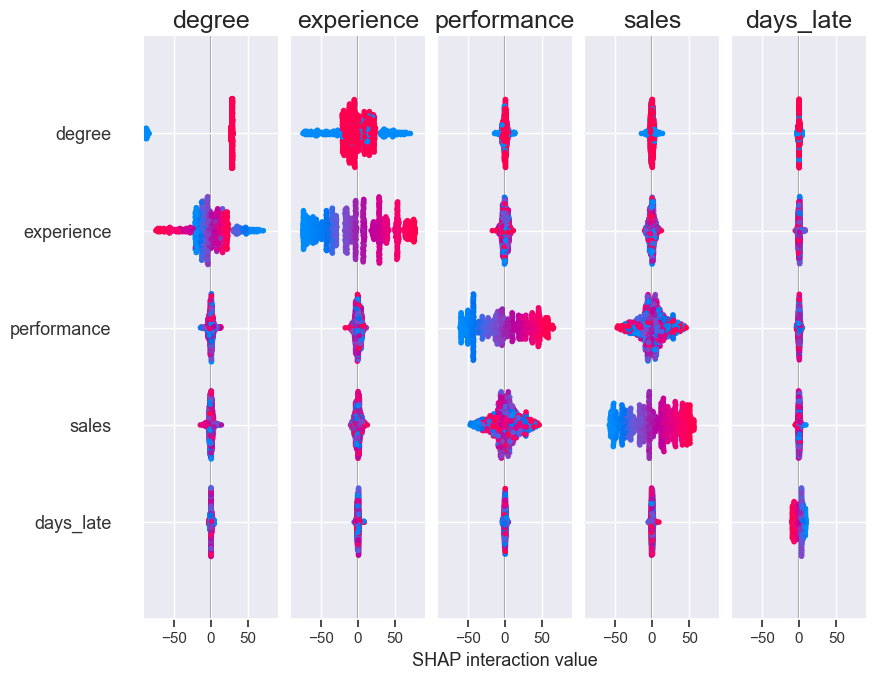

In [14]:
# Display summary plot
shap.summary_plot(shap_interaction, X,show=False)

# plt.savefig('../figures/summary.png',dpi=200,bbox_inches='tight')

### Dependence plot

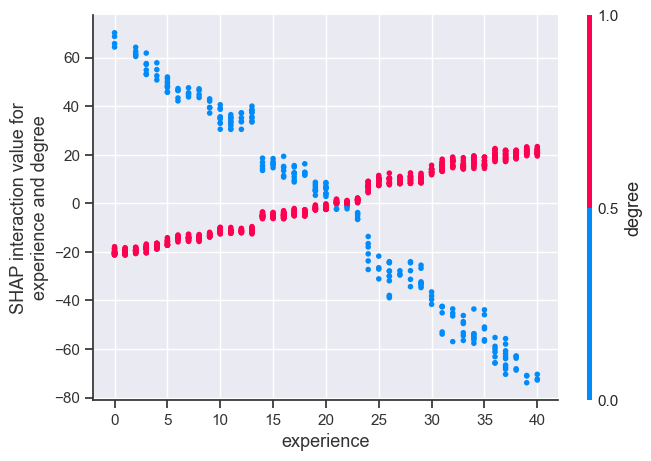

In [15]:
# Experience-degree depenence plot
shap.dependence_plot(
    ("experience", "degree"),
    shap_interaction, X,
    display_features=X,show=False)

# plt.savefig('../figures/exp_degree_dependence.png',dpi=200,bbox_inches='tight')

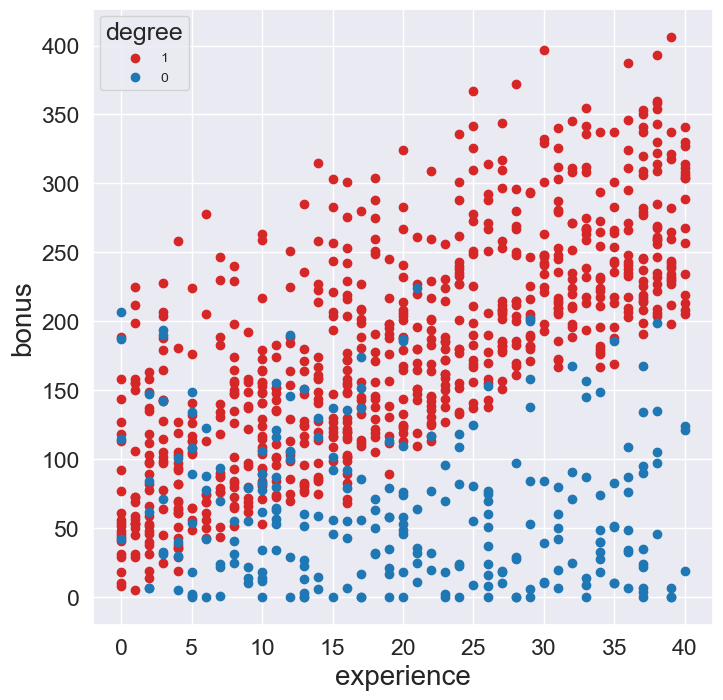

In [16]:
#Model evaluation
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(8,8))


plt.scatter('experience','bonus',data=data[data.degree==1],c='#D62728',label='1')
plt.scatter('experience','bonus',data=data[data.degree==0],c='#1F77B4',label='0')

plt.ylabel('bonus',size=20)
plt.xlabel('experience',size=20)
plt.legend(title='degree',fontsize=10)

# plt.savefig('../figures/experience_degree_scatter.png',dpi=200,bbox_inches='tight')

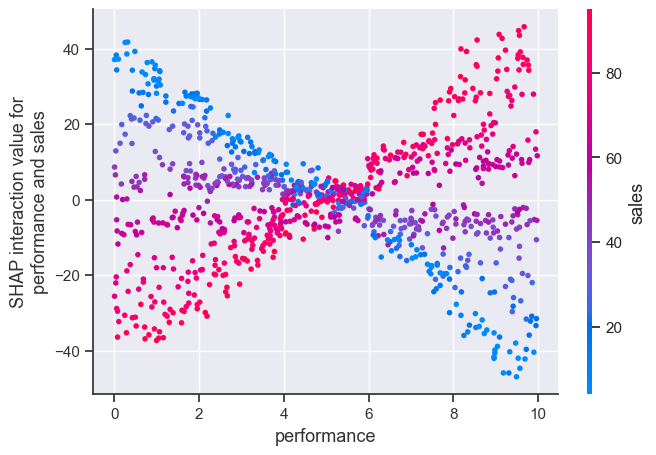

In [17]:
shap.dependence_plot(
    ("performance", "sales"),
    shap_interaction, X,
    display_features=X,show=False)

# plt.savefig('../figures/perf_sales_dependence.png',dpi=200,bbox_inches='tight')